In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicidal-mental-health-dataset/mental-health.csv


In [3]:
import tensorflow as tf
import keras
from keras import layers, optimizers

In [2]:
from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary

In [4]:
from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder

In [31]:
import keras_tuner as kt

In [5]:
from sklearn.model_selection import train_test_split

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('/kaggle/input/suicidal-mental-health-dataset/mental-health.csv')

In [7]:
df['label'] = df['label'].str.replace('SuicideWatch', 'suicidal')
df['label'] = df['label'].str.lower()

binarized = []
for label in df['label']:
    if label == 'suicidal':
        binarized.append(1)
    else:
        binarized.append(0)

binarized = pd.Series(binarized, name='label')
df = df.drop('label', axis=1)
df = pd.concat([df, binarized], axis=1)

In [8]:
train_df, other = train_test_split(
    df,
    test_size = 0.1,
    random_state = 9720,
    shuffle = True,
    stratify = df['label'],
)

In [9]:
val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9720,
    shuffle = True,
    stratify = other['label'],
)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['text'].values, train_df['label'].values)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)

In [11]:
# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

In [12]:
BATCH_SIZE = 64
MAX_SEQLEN = 512
auto = tf.data.AUTOTUNE

In [13]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(auto)

In [14]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b'i hate my mom with all my heart she emotionally and physically abuse me for not being good at anything, yells at me for crying. i want to die, i pray and wish for death every single day. this world is garbage i wish i never exist. i hate my family even my dad who goes to my home country every year and does not send money is better i like him better than my mom. but this happens a lot normally she is nice i just wish she does not bother me. i know other people probably have it worse but i just wanted to vent and explain my situation. my mom yells at me for not being good enough'
0

b'reasons i should not kms? words that may help? idk. i am truly done and i think i have made up my mind. this is my final and last resort.. all jokes aside, i am so close to kms.'
1

b'he says hes angry at my depression and not me, but the reaction is aggressive and it makes me feel worse, i have been shouted at in the past and he does have a temper, so i try to pretend i am happy so i do not make him angr

In [15]:
#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

81609


In [16]:
reserved_tokens = ["[PAD]", "[UNK]"]

In [17]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [18]:
vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [19]:
print(f'Tokens: {vocab[71:99]}')

Tokens: ['the', 'not', 'am', 'it', 'is', 'of', 'have', 'me', 'do', 'that', 'in', 'but', 'just', 'for', 'this', 'so', 'was', 'with', 'like', 'be', 'want', 'feel', 'you', 'all', 'on', 'life', 'or', 'myself']


In [20]:
train_df['text'].apply(lambda x: len(x.split(" "))).describe()

count    18327.000000
mean       166.826649
std        191.245595
min          1.000000
25%         55.500000
50%        111.000000
75%        212.000000
max       6300.000000
Name: text, dtype: float64

In [21]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [22]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b'i hate my mom with all my heart she emotionally and physically abuse me for not being good at anything, yells at me for crying. i want to die, i pray and wish for death every single day. this world is garbage i wish i never exist. i hate my family even my dad who goes to my home country every year and does not send money is better i like him better than my mom. but this happens a lot normally she is nice i just wish she does not bother me. i know other people probably have it worse but i just wanted to vent and explain my situation. my mom yells at me for not being good enough', shape=(), dtype=string)
Tokens:  tf.Tensor(
[  46  178   70  287   88   94   70  511  122  746   69  675  737   78
   84   72  139  168  106  155   13 4928  106   78   84  417   15   46
   91   68  173   13   46 1688   69  231   84  332  177  431  143   15
   85  246   75 1731   46  231   46  135  522   15   46  178   70  172
  112   70  346  151  542   68   70  297  589  177  207   69  1

In [23]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

In [26]:
def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BATCH_SIZE * 8).prefetch(16).cache()

In [27]:
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [28]:
EMBED_DIM = 128
INTERMEDIATE_DIM = 4 * EMBED_DIM

In [45]:
def FentTweaker():
    input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=vocabulary_size,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero=True,
    )(input_ids)
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    #x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
    
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(0.1)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(input_ids, outputs, name="FentTweaker9720")
    model.compile(
        optimizer = optimizers.Adam(learning_rate=5e-3),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )
    return model

In [65]:
FentTweaker9720 = FentTweaker()

In [66]:
FentTweaker9720.summary()

Model: "FentTweaker9720"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_5       │ (None, None, 128)           │      10,511,488 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_10 (FNetEncoder)       │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_11 (FNetEncoder)       │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,776,065 (41.11 MB)

 Trainable params: 10,776,065 (41.11 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
reduceLR = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.1,
    patience = 5,
    verbose = 1,
    mode="auto",
    min_delta = 1e-4,
    cooldown = 0,
    min_lr = 1e-6,
)

In [70]:
earlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = "auto",
    restore_best_weights = True,
    start_from_epoch = 10,
)

In [71]:
history = FentTweaker9720.fit(
    train_dataset,
    epochs=30, 
    validation_data=val_dataset,
    callbacks=[earlyStop, reduceLR]
)

Epoch 1/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.5052 - loss: 0.8041 - val_accuracy: 0.6218 - val_loss: 0.6690 - learning_rate: 0.0050
Epoch 2/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5521 - loss: 0.6834 - val_accuracy: 0.6356 - val_loss: 0.6494 - learning_rate: 0.0050
Epoch 3/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5914 - loss: 0.6652 - val_accuracy: 0.6729 - val_loss: 0.6080 - learning_rate: 0.0050
Epoch 4/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6497 - loss: 0.6257 - val_accuracy: 0.7053 - val_loss: 0.5730 - learning_rate: 0.0050
Epoch 5/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6889 - loss: 0.5935 - val_accuracy: 0.7210 - val_loss: 0.5542 - learning_rate: 0.0050
Epoch 6/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7106 - loss: 0.5676 - val_accuracy: 0.7250 - val_loss: 0.5607 - learning_rate: 0.0050
Epoch 7/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7482 - loss

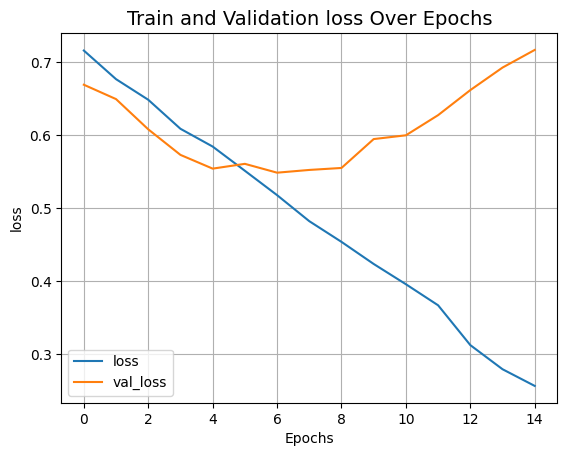

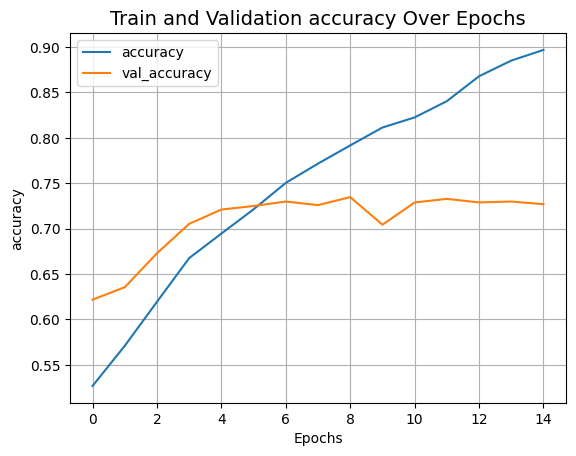

In [72]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [73]:
FentTweaker9720.evaluate(test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7134 - loss: 0.6187


[0.6447161436080933, 0.6977428793907166]